In [6]:
import sys
sys.path.append('../ST-MetaNet-DCU-regularization')

import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

import numpy as np
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
import os
import yaml
import logging
import argparse
import random
import h5py
from datetime import datetime, timedelta

import config
from config import PARAM_PATH

# Set logging
current_time = datetime.now()
formatted_time = current_time.strftime('%Y%m%d-%H%M%S')

import model
import data.dataloader
from data.dataloader import get_geo_feature


In [7]:
# Load settings
with open('../ST-MetaNet-DCU-regularization/model_setting/st-metanet.yaml', 'r') as f:
    settings = yaml.safe_load(f)

np.random.seed(settings['seed'])
tf.random.set_seed(settings['seed'])
random.seed(settings['seed'])

dataset_setting = settings['dataset']
model_setting = settings['model']
train_setting = settings['training']

# set meta hiddens
if 'meta_hiddens' in model_setting.keys():
    config.MODEL['meta_hiddens'] = model_setting['meta_hiddens']

# load model
model_type = getattr(model, model_setting['type'])
net = model_type.net(settings) # initialize model

In [8]:
# Data setup
_, _, test_data, scaler = getattr(data.dataloader, dataset_setting['dataloader'])(settings)

# inference for one time to call the model for loading params
node_features, _ = get_geo_feature()
for i, (history, label, data_ts, label_ts) in enumerate(test_data):
    history = tf.transpose(history, perm=[1, 0, 2, 3])  # [b, t, n, d] to [n, b, t, d]
    label = tf.transpose(label, perm=[1, 0, 2, 3])
    if i == 0:
        _, _ = net(node_features, history, label, is_training=False)
    else:
        break

In [9]:
lambda_list = [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 1, 10]
tois = ['2019-11-10 03:44:00','2019-11-10 09:44:00','2019-11-10 15:44:00','2019-11-10 21:44:00'] # Sunday, time of interest

from tqdm import tqdm
import h5py

rho_big = []
for toi in tois:
    rho = []
    for l in tqdm(lambda_list[:9]):
        net.load_weights(f'../param/st-metanet-DCU-reg-lambda{l}.h5')
    
        _, _, test_data, scaler = getattr(data.dataloader, dataset_setting['dataloader'])(settings)
        
        # inference
        node_features, _ = get_geo_feature()
        
        for _, (history, label, history_ts, label_ts) in enumerate(test_data):
            if toi in label_ts:
                history = tf.transpose(history, perm=[1, 0, 2, 3])  # [b, t, n, d] to [n, b, t, d]
                label = tf.transpose(label, perm=[1, 0, 2, 3])
                for i, tsp in enumerate(label_ts):
                    if tf.reduce_any(tf.equal(tsp, toi)):
                        batch_index = i
                        break
                history = history[:, batch_index:batch_index+1, :, :]
                label = label[:, batch_index:batch_index+1, :, :]
                _, rho_temp = net(node_features, history, label, is_training=False)
                break
        rho.append(tf.reduce_mean(tf.squeeze(rho_temp), axis=-1))
    rho = tf.stack(rho, axis=0)
    rho_big.append(rho)
rho_big = tf.stack(rho_big, axis=0)
with h5py.File('rho_matrix.h5', 'w') as f:  
    dataset = f.create_dataset('rho_matrix', data=rho_big.numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:33<00:00,  3.76s/it]


In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance

edge_feature = pd.read_excel('../data/tris_edge_features.xlsx')

london_center = (51.505540, -0.075607)

# Calculating distances from the center of London to each sensor
edge_feature['Distance_to_London'] = edge_feature.apply(lambda row: distance.euclidean((row['Latitude'], row['Longitude']), london_center), axis=1)

# Sorting the DataFrame based on the calculated distances
df_sorted = edge_feature.sort_values(by='Distance_to_London')
sorted_indices = df_sorted.index.to_list()

In [2]:
tois = ['2019-11-10 03:44:00','2019-11-10 09:44:00','2019-11-10 15:44:00','2019-11-10 21:44:00'] # Sumday, time of interest
lambda_list = ['-inf', '-4', '-3.5', '-3', '-2.5', '-2', '-1.5', '-1', '0']

In [3]:
with h5py.File('rho_matrix.h5', 'r') as f:  
    rho = f['rho_matrix'][:]
rho = rho[:, :, sorted_indices, :]


In [4]:
rho.shape

(4, 9, 498, 13)

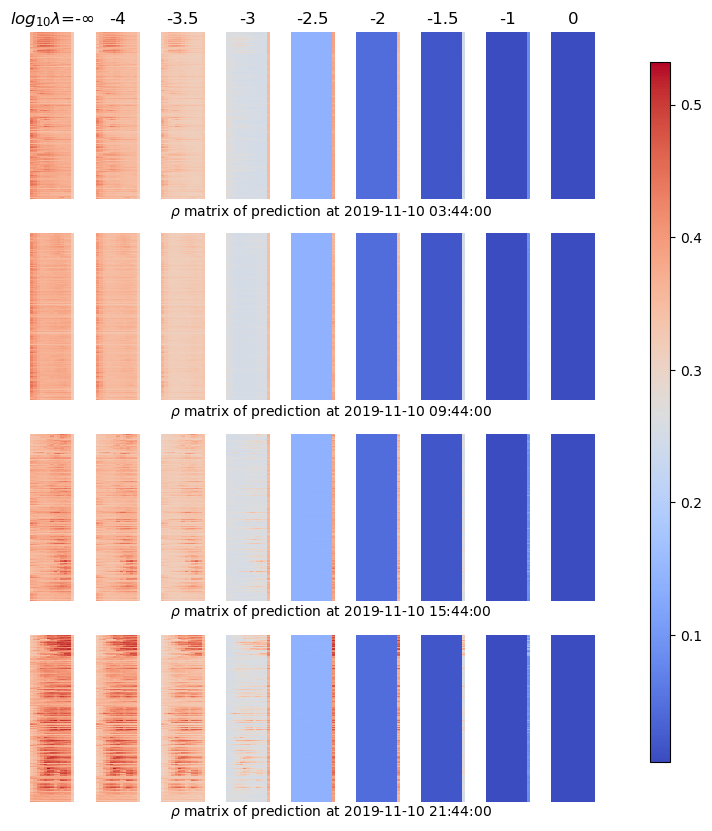

In [6]:
data_3d = np.repeat(rho, 10, axis=3)

# Determining the common color scale across all plots
vmin = data_3d.min()
vmax = data_3d.max()

# Creating 9 heat maps
fig, axs = plt.subplots(len(tois), 9, figsize=(10, 10))  # Arranging the plots in a 3x3 grid
#fig.suptitle('Heat Maps for Each Slice Along the First Axis with a Uniform Color Scale')

for j in range(len(tois)):
    for i in range(9):
        ax = axs[j, i]
        heatmap = ax.imshow(data_3d[j,i,:,:], cmap='coolwarm', interpolation='nearest', vmin=vmin, vmax=vmax)
        if j == 0:
            if i == 0:
                ax.set_title(r'$log_{10}\lambda$=-$\infty$')
            else:
                ax.set_title(f'{lambda_list[i]}')
        ax.axis('off')  # Hide axis for clarity
    y_text = -0.20*j + 0.7
    fig.text(0.27, y_text, r'$\rho$ matrix of prediction at '+tois[j], ha='left', va='center')


# Adding a color bar
fig.subplots_adjust(right=0.7)
cbar_ax = fig.add_axes([0.75, 0.15, 0.02, 0.7])
fig.colorbar(heatmap, cax=cbar_ax)

plt.savefig('Rho-30min-12-1-Sun.png')
plt.show()